In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics

## Import, Basic EDA and Sanitization:

In [3]:
pre_split_training_data = pd.read_csv('./data/cs-training.csv', index_col='Unnamed: 0')
test_data = pd.read_csv('./data/cs-test.csv', index_col='Unnamed: 0')
sample_entry = pd.read_csv('./data/sampleEntry.csv')

In [4]:
pre_split_training_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [5]:
pre_split_training_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Removes Rows with Missing Dependents:

In [6]:
pre_split_training_data = pre_split_training_data[pre_split_training_data['age'] >= 20]
len(pre_split_training_data)

149999

### Split Data into Training and Validation Sets:

In [7]:
from sklearn.model_selection import train_test_split

# split indices instead of separate X/y
train_idx, val_idx = train_test_split(
    pre_split_training_data.index,
    test_size=0.2,
    random_state=42,
    stratify=pre_split_training_data['SeriousDlqin2yrs']
)

train_df = pre_split_training_data.loc[train_idx]
val_df   = pre_split_training_data.loc[val_idx]

## Feature Engineering:

In [8]:
train_df['age'].isna().sum()

np.int64(0)

In [9]:
# Model 1: Age

# Training set binning of age
train_df['age_bin'] = pd.cut(train_df['age'], bins=[20,30,40,50,60,70,80,110], right=False )
train_df['age_bin_mid'] = train_df['age_bin'].apply(lambda x: (x.left + x.right)/2)

# Validation set binning of age
val_df['age_bin'] = pd.cut(val_df['age'], bins=[20,30,40,50,60,70,80,110], right=False)
val_df['age_bin_mid'] = val_df['age_bin'].apply(lambda x: (x.left + x.right)/2)


# Model 2: Debt Ratio
max_clip = 3

# Training set binning DebtRatio
train_df['DebtRatio'] = train_df['DebtRatio'].clip(upper=max_clip)
train_df['DebtRatio_bin'] = pd.cut(train_df['DebtRatio'], bins=[0, 0.25, 0.5, 0.75, 1, 
                                                                1.25, 1.5, 1.75, 2, 
                                                                2.25, 2.5, 2.75, 3.001,
                                                               ], right=False, include_lowest=True)
train_df['DebtRatio_bin_mid'] = train_df['DebtRatio_bin'].apply(lambda x: (x.left + x.right)/2)

# Validation set binning of age
val_df['DebtRatio'] = val_df['DebtRatio'].clip(upper=max_clip)
val_df['DebtRatio_bin'] = pd.cut(val_df['DebtRatio'], bins=[0, 0.25, 0.5, 0.75, 1, 
                                                                1.25, 1.5, 1.75, 2, 
                                                                2.25, 2.5, 2.75, 3.001,
                                                               ], right=False, include_lowest=True)
val_df['DebtRatio_bin_mid'] = val_df['DebtRatio_bin'].apply(lambda x: (x.left + x.right)/2)

In [10]:
# Model 3: Delinquencies

# Training Set
# 30-60 day, clip at 4 (EDA is in Feature 3 section)
train_df['NumberOfTime60-89DaysPastDueNotWorse'] = train_df['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=4)
# 60-90 day, clip at 4 (EDA is in Feature 3 section)
train_df['NumberOfTime30-59DaysPastDueNotWorse'] = train_df['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=4)
# 90 day, clip at 4 (EDA is in Feature 3 section)
train_df['NumberOfTimes90DaysLate'] = train_df['NumberOfTimes90DaysLate'].clip(upper=4)

# Validation Set
# 30-60 day, clip at 4 (EDA is in Feature 3 section)
val_df['NumberOfTime60-89DaysPastDueNotWorse'] = val_df['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=4)
# 60-90 day, clip at 4 (EDA is in Feature 3 section)
val_df['NumberOfTime30-59DaysPastDueNotWorse'] = val_df['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=4)
# 90 day, clip at 4 (EDA is in Feature 3 section)
val_df['NumberOfTimes90DaysLate'] = val_df['NumberOfTimes90DaysLate'].clip(upper=4)

#Model 4: RevolvingUtilizationOfUnsecuredLines

# Training Set
train_df['RevolvingUtilizationOfUnsecuredLines'] = train_df['RevolvingUtilizationOfUnsecuredLines'].clip(lower=0, upper=3)
train_df['log_RevolvingUtilizationOfUnsecuredLines'] = np.log1p(train_df['RevolvingUtilizationOfUnsecuredLines'])

# Validation Set
val_df['RevolvingUtilizationOfUnsecuredLines'] = val_df['RevolvingUtilizationOfUnsecuredLines'].clip(lower=0, upper=3)
val_df['log_RevolvingUtilizationOfUnsecuredLines'] = np.log1p(val_df['RevolvingUtilizationOfUnsecuredLines'])

In [11]:
# Model 5: Monthly Income

# Training Set
train_df['MonthlyIncome_missing'] = train_df['MonthlyIncome'].isna().astype(int)
income_median = train_df['MonthlyIncome'].median()
train_df['MonthlyIncome_imputed'] = train_df['MonthlyIncome'].fillna(income_median)
train_df['MonthlyIncome_imputed'] = train_df['MonthlyIncome_imputed'].clip(lower=0, upper=50000)

# Validation Set
val_df['MonthlyIncome_missing'] = val_df['MonthlyIncome'].isna().astype(int)
val_df['MonthlyIncome_imputed'] = val_df['MonthlyIncome'].fillna(income_median)
val_df['MonthlyIncome_imputed'] = val_df['MonthlyIncome_imputed'].clip(lower=0, upper=50000)

# Model 6: NumberOfOpenCreditLinesAndLoans

# Training Set
train_df['NumberOfOpenCreditLinesAndLoans'] = train_df['NumberOfOpenCreditLinesAndLoans'].clip(lower=0, upper=40)

# Validation Set
val_df['NumberOfOpenCreditLinesAndLoans'] = val_df['NumberOfOpenCreditLinesAndLoans'].clip(lower=0, upper=40)

## Feature 1: Age, Binned into Decades:


In [12]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid,DebtRatio_bin,DebtRatio_bin_mid,log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome_missing,MonthlyIncome_imputed
57837,0,0.114987,62,0,3.000000,NaN,5,0,1,0,2.0,"[60, 70)",65.0,"[2.75, 3.001)",2.8755,0.108843,1,5400.0
132897,0,0.666105,46,0,0.419041,7404.0,3,0,1,0,3.0,"[40, 50)",45.0,"[0.25, 0.5)",0.3750,0.510489,0,7404.0
27982,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.194334,0,3716.0
21713,0,0.030495,32,0,0.022753,69000.0,8,0,1,0,0.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.030039,0,50000.0
103815,0,0.110935,50,0,3.000000,NaN,8,0,1,0,0.0,"[50, 60)",55.0,"[2.75, 3.001)",2.8755,0.105202,1,5400.0


### EDA - Age

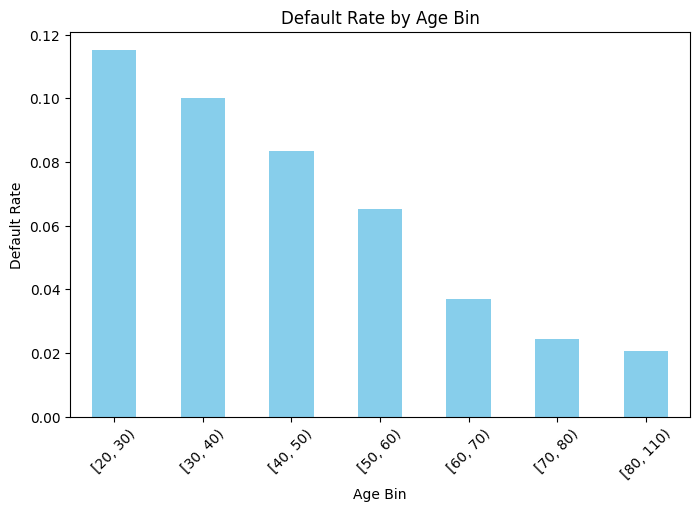

In [13]:
rate_per_bin = train_df.groupby('age_bin', observed=True)['SeriousDlqin2yrs'].mean()
plt.figure(figsize=(8,5))
rate_per_bin.plot(kind='bar', color='skyblue')
plt.xlabel('Age Bin')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Bin')
plt.xticks(rotation=45)
plt.show()

In [14]:
# The trend shows a consistent, near linear decrease of defaults with age.  
# I will use a midpoint for each age decade to train the model:

### Model 1 - Training

In [15]:
X_model1 = train_df[['age_bin_mid']]
Y_model1 = train_df['SeriousDlqin2yrs']
# print(training_data['age_bin_mid'].isna().sum())    for debugging
# mask = X['age_bin_mid'].notna()

In [16]:
Y_model1.head()

57837     0
132897    0
27982     0
21713     0
103815    0
Name: SeriousDlqin2yrs, dtype: int64

In [17]:
from sklearn.linear_model import LogisticRegression

# initialize the model
model = LogisticRegression(C=1e6)

# fit the model
model.fit(X_model1, Y_model1)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1000000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [18]:
X_test = pd.DataFrame([[25], [45], [95]], columns=['age_bin_mid']) 
print(model.predict(X_test))
print(model.predict_proba(X_test))

[0 0 0]
[[0.86682245 0.13317755]
 [0.92290482 0.07709518]
 [0.98211632 0.01788368]]


In [19]:
# About the above: predictions are in line with the probabilities for each age group. 
# Age is weak feature and will not or rarely push the probability above 50% for even the higher risk age group
# Probabilities of defaut lower with age

In [20]:
# create a smooth age range
age_grid = np.linspace(
    train_df['age'].min(),
    train_df['age'].max(),
    200
)

# build model input as dataframe
X_age = pd.DataFrame({'age_bin_mid': age_grid})

# predict probabilities
pred_probs = model.predict_proba(X_age)[:, 1]

# build dataframe for plotting
plot_df = pd.DataFrame({
    'Age': age_grid,
    'Predicted Default Probability': pred_probs
})

# plot
fig = px.line(
    plot_df,
    x='Age',
    y='Predicted Default Probability',
    title='Age vs Predicted Probability of Serious Delinquency'
)

fig.update_layout(
    yaxis_tickformat='.1%',
    xaxis_title='Age',
    yaxis_title='Predicted Probability of Serious Delinquency',
    template='plotly_white'
)

fig.show()

### Model 1 - Accuracy Calculation:

In [21]:
# Accuracy for training set:
model.score(X_model1, Y_model1)

0.9331577763148027

In [22]:
X_val_model1 = val_df[['age_bin_mid']]
Y_val_model1 = val_df['SeriousDlqin2yrs']

In [23]:
# Accuracy for validation set:
model.score(X_val_model1, Y_val_model1)

0.9331666666666667

In [24]:
# Takes in a model, X, and a threshold and computes the predicted labels (1s and 0s) at that threshold
def predict_threshold(model, X, threshold): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= threshold).astype(int)

# Takes in a model, a true y, an x, a d a threshold 
# and return the accuracy of the predictions for our model with that threshold
def accuracy_custom_threshold(model, X, y, threshold):
    y_pred = predict_threshold(model, X, threshold)
    return np.mean(y_pred == y)

In [25]:
accuracy_custom_threshold(model,X_val_model1, Y_val_model1, 0.5)

np.float64(0.9331666666666667)

In [26]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs = [accuracy_custom_threshold(model, X_val_model1, Y_val_model1, t) for t in thresholds]

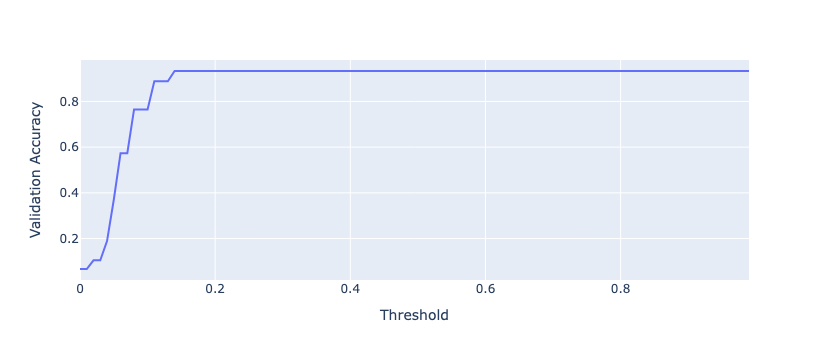

In [27]:
fig = px.line(x=thresholds, y=accs)
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Validation Accuracy")

In [28]:
# The threshold that maximizes validation accuracy
np.argmax(accs)

np.int64(14)

### Model 1 - Precision and Recall Calucations:

It seems we can get a very high accuracy. What about precision and recall?

Precision (also called positive predictive value) is the fraction of true positives among the total number of data points predicted as positive.
Recall (also known as sensitivity) is the fraction of true positives among the total number of data points with positive labels.
Precision measures the ability of our classifier to not predict negative samples as positive (i.e., avoid false positives), while recall is the ability of the classifier to find all the positive samples (i.e., avoid false negatives).

In [29]:
# Precision Calculation 
# “Of the cases I predicted as positive, how many were actually positive?”

def precision_custom_threshold(model, X, y, threshold):
    y_pred = predict_threshold(model, X, threshold)
    tp = np.sum((y_pred == 1) & (y == 1))
    fp = np.sum((y_pred == 1) & (y == 0))
    if tp == 0 & fp == 0:
        return 0
    return tp / (tp + fp)

precision_custom_threshold(model, X_val_model1, Y_val_model1, 0.5)

0

In [30]:
# Recall Calculation
# “Of all the actual positives, how many did I correctly identify?”

def recall_custom_threshold(model, X, y, threshold):
    y_pred = predict_threshold(model, X, threshold)
    tp = np.sum((y_pred == 1) & (y == 1))
    fn = np.sum((y_pred == 0) & (y == 1))
    if tp == 0 & fn == 0:
        return 0
    return tp / (tp + fn)

recall_custom_threshold(model, X_val_model1, Y_val_model1, 0.5)

0

In [31]:
precs = [precision_custom_threshold(model, X_val_model1, Y_val_model1, t) for t in thresholds]
recs = [recall_custom_threshold(model, X_val_model1, Y_val_model1,t) for t in thresholds]

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 1:')

In [33]:
# Looking for: A point where recall drops sharply but precision only improves marginally
# This is often the sweet spot

# Interpretation:
# At threshold = 0.05, Precision: 0.084, Recall: 0.85
# We dropped 15% of true defaulters but precision barely improved (7% → 8.4%)
# Precision peaks around 0.13, recall keeps falling rapidly
# Even at its best, this feature only gets us to ~13% precision
# This is typical for rare events, or single feature logistic models and weak but real predictors

# Conclusion:
# Age barely improves precision, it destroys recall very quickly 
# and it cannot, on its own, separate defaulters well

# Future Features:
# Adding good complementary features, we should see:
# Precision increasing more than a few percentage points
# Recall declining more slowly
# Non-zero precision at higher thresholds
# A wider “useful” threshold band
# If that doesn’t happen: the new feature isn’t helping.

### Precision-Recall Curves

In [34]:
fig = px.line(x=recs, y=precs, hover_name=thresholds)
fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")

## Feature 2: Debt Ratio:

In [35]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid,DebtRatio_bin,DebtRatio_bin_mid,log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome_missing,MonthlyIncome_imputed
57837,0,0.114987,62,0,3.000000,NaN,5,0,1,0,2.0,"[60, 70)",65.0,"[2.75, 3.001)",2.8755,0.108843,1,5400.0
132897,0,0.666105,46,0,0.419041,7404.0,3,0,1,0,3.0,"[40, 50)",45.0,"[0.25, 0.5)",0.3750,0.510489,0,7404.0
27982,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.194334,0,3716.0
21713,0,0.030495,32,0,0.022753,69000.0,8,0,1,0,0.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.030039,0,50000.0
103815,0,0.110935,50,0,3.000000,NaN,8,0,1,0,0.0,"[50, 60)",55.0,"[2.75, 3.001)",2.8755,0.105202,1,5400.0


### EDA - Debt Ratio

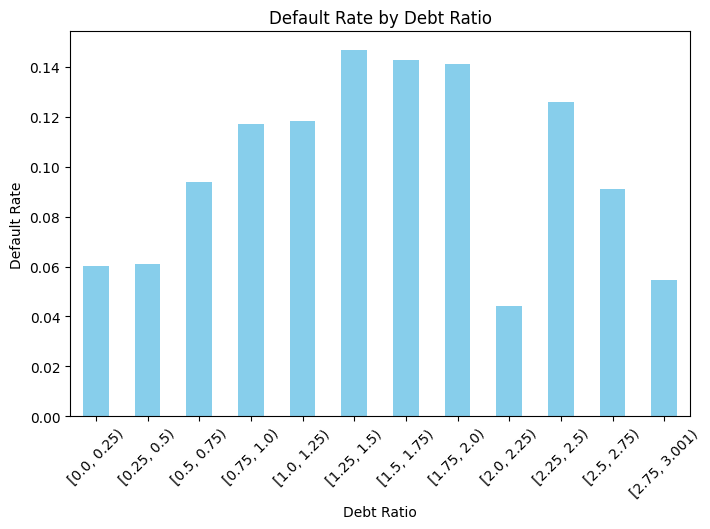

In [36]:
rate_per_bin = train_df.groupby('DebtRatio_bin', observed=True)['SeriousDlqin2yrs'].mean()
plt.figure(figsize=(8,5))
rate_per_bin.plot(kind='bar', color='skyblue')
plt.xlabel('Debt Ratio')
plt.ylabel('Default Rate')
plt.title('Default Rate by Debt Ratio')
plt.xticks(rotation=45)
plt.show()

In [37]:
# print(train_df[train_df['DebtRatio'].isna()])
# train_df['DebtRatio_bin'].isna().sum()
# train_df['DebtRatio'].describe()

### Model 2 - Training

In [38]:
X_model2 = train_df[['age_bin_mid', 'DebtRatio_bin_mid']]
Y_model2 = train_df['SeriousDlqin2yrs']

In [39]:
# initialize the model
model2 = LogisticRegression(C=1e6)

# fit the model
model2.fit(X_model2, Y_model2)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1000000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [40]:
X_test2 = pd.DataFrame([[25, 1.5], [45, 1.5], [85, 1.5]], columns=['age_bin_mid', 'DebtRatio_bin_mid']) 
print(model2.predict(X_test2))
print(model2.predict_proba(X_test2))

[0 0 0]
[[0.86590112 0.13409888]
 [0.92243387 0.07756613]
 [0.97580857 0.02419143]]


### Model 2 - Accuracy Calculation:

In [41]:
# Accuracy for training set:
model2.score(X_model2, Y_model2)

0.9331577763148027

In [42]:
X_val_model2 = val_df[['age_bin_mid', 'DebtRatio_bin_mid']]
Y_val_model2 = val_df['SeriousDlqin2yrs']

In [43]:
# Accuracy for validation set:
model2.score(X_val_model2, Y_val_model2)

0.9331666666666667

In [44]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs2 = [accuracy_custom_threshold(model2, X_val_model2, Y_val_model2, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs2)

np.int64(14)

### Model 2 - Precision and Recall Calculations:

In [45]:
precs2 = [precision_custom_threshold(model2, X_val_model2, Y_val_model2, t) for t in thresholds]
recs2 = [recall_custom_threshold(model2, X_val_model2, Y_val_model2, t) for t in thresholds]

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs2))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs2))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 2:')

In [47]:
# Looking for: A point where recall drops sharply but precision only improves marginally
# This is often the sweet spot

# Interpretation:
# At threshold = 0.05, precision is 0.0847 and recall is 0.859.
# Compared to the base rate (~6.6%), precision improves only marginally while recall drops by ~14%.
# Precision peaks around ~0.1259, but recall continues to decline rapidly.
# This two-feature model still exhibits weak separation.
# We see non-zero precision at higher thresholds

# Conclusion:
# Adding DebtRatio to Age provides a small drop in performance and 
# does not materially improve class separation.
# The model remains weakly discriminative, which is typical for rare-event prediction 
# using a small number of demographic and financial ratio features.

# Future Features:
# Adding good complementary features, we should see:
# Precision increasing more than a few percentage points
# Recall declining more slowly
# Non-zero precision at higher thresholds
# A wider “useful” threshold band
# If that doesn’t happen: the new feature isn’t helping.

## Feature 3: Delinquencies

In [48]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid,DebtRatio_bin,DebtRatio_bin_mid,log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome_missing,MonthlyIncome_imputed
57837,0,0.114987,62,0,3.000000,NaN,5,0,1,0,2.0,"[60, 70)",65.0,"[2.75, 3.001)",2.8755,0.108843,1,5400.0
132897,0,0.666105,46,0,0.419041,7404.0,3,0,1,0,3.0,"[40, 50)",45.0,"[0.25, 0.5)",0.3750,0.510489,0,7404.0
27982,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.194334,0,3716.0
21713,0,0.030495,32,0,0.022753,69000.0,8,0,1,0,0.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.030039,0,50000.0
103815,0,0.110935,50,0,3.000000,NaN,8,0,1,0,0.0,"[50, 60)",55.0,"[2.75, 3.001)",2.8755,0.105202,1,5400.0


In [49]:
# copy train_df for EDA for delinquincies so as to not impact raw training data
# feature engineering occurs above in Feature Engineering section
eda_df = train_df.copy()

### EDA: NumberOfTime30-59DaysPastDueNotWorse

In [50]:
eda_df['NumberOfTime30-59DaysPastDueNotWorse'].describe()

count    119999.000000
mean          0.245660
std           0.665696
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

In [51]:
eda_df['NumberOfTime30-59DaysPastDueNotWorse'] = eda_df['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=4)
counts1 = eda_df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts().sort_index()

fig = px.bar(
    x=counts1.index,
    y=counts1.values,
    labels={'x': 'NumberOfTime30-59DaysPastDueNotWorse', 'y': 'Count'},
    title='Count of Observations by NumberOfTime30-59DaysPastDueNotWorse'
)

fig.show()

print('30-59 days past due not worse rows:', len(eda_df['NumberOfTime30-59DaysPastDueNotWorse']))

30-59 days past due not worse rows: 119999


In [52]:
counts1

NumberOfTime30-59DaysPastDueNotWorse
0    100822
1     12793
2      3716
3      1418
4      1250
Name: count, dtype: int64

In [53]:
default_rate1 = eda_df.groupby('NumberOfTime30-59DaysPastDueNotWorse', observed=True)['SeriousDlqin2yrs'].mean().reset_index()

fig = px.bar(
    default_rate1,
    x='NumberOfTime30-59DaysPastDueNotWorse',
    y='SeriousDlqin2yrs',
    labels={'SeriousDlqin2yrs': 'Default Rate', 'NumberOfTime30-59DaysPastDueNotWorse': 'NumberOfTime30-59DaysPastDueNotWorse'},
    title='Default Rate by NumberOfTime30-59DaysPastDueNotWorse'
)

fig.show()

### EDA: NumberOfTime60-89DaysPastDueNotWorse

In [54]:
eda_df['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    119999.000000
mean          0.071601
std           0.359711
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [55]:
eda_df['NumberOfTime60-89DaysPastDueNotWorse'] = eda_df['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=4)
counts2 = eda_df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

fig = px.bar(
    x=counts2.index,
    y=counts2.values,
    labels={'x': 'NumberOfTime60-89DaysPastDueNotWorse', 'y': 'Count'},
    title='Count of Observations by NumberOfTime60-89DaysPastDueNotWorse'
)

fig.show()

print('60-89 days past due not worse rows:', len(eda_df['NumberOfTime60-89DaysPastDueNotWorse']))

60-89 days past due not worse rows: 119999


In [56]:
counts2

NumberOfTime60-89DaysPastDueNotWorse
0    113859
1      4656
2       871
3       258
4       355
Name: count, dtype: int64

In [57]:
default_rate2 = eda_df.groupby('NumberOfTime60-89DaysPastDueNotWorse', observed=True)['SeriousDlqin2yrs'].mean().reset_index()

fig = px.bar(
    default_rate2,
    x='NumberOfTime60-89DaysPastDueNotWorse',
    y='SeriousDlqin2yrs',
    labels={'SeriousDlqin2yrs': 'Default Rate', 'NumberOfTime60-89DaysPastDueNotWorse': 'NumberOfTime60-89DaysPastDueNotWorse'},
    title='Default Rate by NumberOfTime60-89DaysPastDueNotWorse'
)

fig.show()

### EDA: NumberOfTimes90DaysLate

In [58]:
eda_df['NumberOfTimes90DaysLate'].describe()

count    119999.000000
mean          0.092176
std           0.446988
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [59]:
eda_df['NumberOfTimes90DaysLate'] = eda_df['NumberOfTimes90DaysLate'].clip(upper=4)
counts3 = eda_df['NumberOfTimes90DaysLate'].value_counts().sort_index()

fig = px.bar(
    x=counts3.index,
    y=counts3.values,
    labels={'x': 'NumberOfTimes90DaysLate', 'y': 'Count'},
    title='Count of Observations by NumberOfTimes90DaysLate'
)

fig.show()

print('90 days late rows:', len(eda_df['NumberOfTimes90DaysLate']))

90 days late rows: 119999


In [60]:
counts3

NumberOfTimes90DaysLate
0    113303
1      4239
2      1243
3       520
4       694
Name: count, dtype: int64

In [61]:
default_rate3 = eda_df.groupby('NumberOfTimes90DaysLate', observed=True)['SeriousDlqin2yrs'].mean().reset_index()

fig = px.bar(
    default_rate3,
    x='NumberOfTimes90DaysLate',
    y='SeriousDlqin2yrs',
    labels={'SeriousDlqin2yrs': 'Default Rate', 'NumberOfTimes90DaysLate': 'NumberOfTimes90DaysLate'},
    title='Default Rate by NumberOfTimes90DaysLate'
)

fig.show()

### Model 3 - Training

In [62]:
X_model3 = train_df[['age_bin_mid', 
                     'DebtRatio_bin_mid', 
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate'
                    ]]
Y_model3 = train_df['SeriousDlqin2yrs']

In [63]:
# initialize the model
model3 = LogisticRegression(C=1e6)

# fit the model
model3.fit(X_model3, Y_model3)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1000000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [64]:
X_test3 = pd.DataFrame([[25, 1.5, 2, 1, 0], [45, 1.5, 2, 0, 1], [95, 1.5, 0, 1, 0]], 
                      columns=[
                          'age_bin_mid', 
                          'DebtRatio_bin_mid',
                          'NumberOfTime30-59DaysPastDueNotWorse',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                          'NumberOfTimes90DaysLate'
                      ])

print(model3.predict(X_test3))
print(model3.predict_proba(X_test3))

[0 0 0]
[[0.67726327 0.32273673]
 [0.71618454 0.28381546]
 [0.97638594 0.02361406]]


### Model 3 - Accuracy Calculation:

In [65]:
# Accuracy for training set:
model3.score(X_model3, Y_model3)

0.9363828031900265

In [66]:
X_val_model3 = val_df[['age_bin_mid', 
                       'DebtRatio_bin_mid', 
                       'NumberOfTime30-59DaysPastDueNotWorse',
                       'NumberOfTime60-89DaysPastDueNotWorse',
                       'NumberOfTimes90DaysLate'
                      ]]
Y_val_model3 = val_df['SeriousDlqin2yrs']

In [67]:
# Accuracy for validation set:
model3.score(X_val_model3, Y_val_model3)

0.936

In [68]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs3 = [accuracy_custom_threshold(model3, X_val_model3, Y_val_model3, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs3)

np.int64(59)

### Model 3 - Precision and Recall Calculations:

In [69]:
precs3 = [precision_custom_threshold(model3, X_val_model3, Y_val_model3, t) for t in thresholds]
recs3 = [recall_custom_threshold(model3, X_val_model3, Y_val_model3, t) for t in thresholds]

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs3))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs3))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 3:')

In [71]:
# Looking for: A point where recall drops sharply but precision only improves marginally
# This is often the sweet spot

# Interpretation:
# Precision no longer collapses to zero, and recall now declines more gradually as the threshold increases.
# The precision–recall curves intersect around a threshold of 0.14, 
# corresponding to flagging roughly 41.4% of the population as high risk.
# The remaining sharp decline in recall (exponential-like decay) indicates the model is strong at 
# identifying the highest-risk borrowers, but still has limited resolution among mid-risk applicants.

# Conclusion:
# Adding the three delinquency features produced a substantial improvement in both precision and recall.
# These features provide strong ranking power for default risk and materially improve model separation.
# The model is now capturing meaningful signal and is on a solid path toward higher-fidelity risk 
# stratification, with further gains likely from additional complementary features.

# Future Features:
# Adding complementary features, we should see:
# Precision increasing more and the recall band dropping less sharply and behaving more linearly.

## Feature 4: RevolvingUtilizationOfUnsecuredLines

In [72]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid,DebtRatio_bin,DebtRatio_bin_mid,log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome_missing,MonthlyIncome_imputed
57837,0,0.114987,62,0,3.000000,NaN,5,0,1,0,2.0,"[60, 70)",65.0,"[2.75, 3.001)",2.8755,0.108843,1,5400.0
132897,0,0.666105,46,0,0.419041,7404.0,3,0,1,0,3.0,"[40, 50)",45.0,"[0.25, 0.5)",0.3750,0.510489,0,7404.0
27982,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.194334,0,3716.0
21713,0,0.030495,32,0,0.022753,69000.0,8,0,1,0,0.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.030039,0,50000.0
103815,0,0.110935,50,0,3.000000,NaN,8,0,1,0,0.0,"[50, 60)",55.0,"[2.75, 3.001)",2.8755,0.105202,1,5400.0


### EDA - RevolvingUtilizationOfUnsecuredLines

In [73]:
train_df['RevolvingUtilizationOfUnsecuredLines'].describe()

count    119999.000000
mean          0.326333
std           0.377480
min           0.000000
25%           0.029663
50%           0.153211
75%           0.558129
max           3.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

Text(0.5, 0, 'Slope')

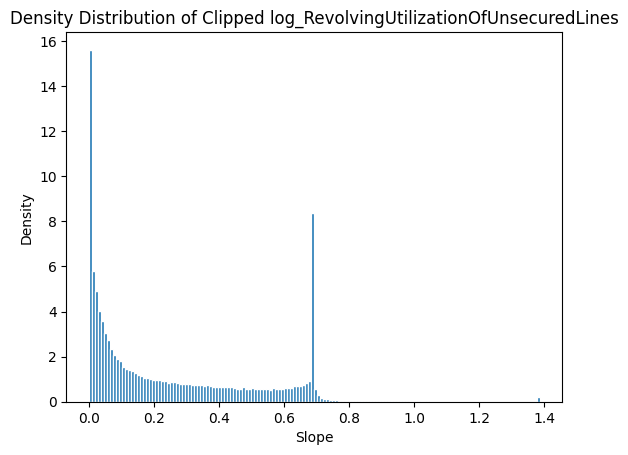

In [74]:
eda_df['RevolvingUtilizationOfUnsecuredLines'] = eda_df['RevolvingUtilizationOfUnsecuredLines'].clip(lower=0, upper=3)
eda_df['log_RevolvingUtilizationOfUnsecuredLines'] = np.log1p(eda_df['RevolvingUtilizationOfUnsecuredLines'])

plt.hist(eda_df['log_RevolvingUtilizationOfUnsecuredLines'], bins=150, ec='white', density=True)
plt.title('Density Distribution of Clipped log_RevolvingUtilizationOfUnsecuredLines')
plt.ylabel('Density')
plt.xlabel('Slope')

### Model 4 - Training

In [75]:
X_model4 = train_df[['age_bin_mid', 
                     'DebtRatio_bin_mid', 
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate',
                     'log_RevolvingUtilizationOfUnsecuredLines',
                    ]]
Y_model4 = train_df['SeriousDlqin2yrs']

In [76]:
# initialize the model
model4 = LogisticRegression(C=1e6)

# fit the model
model4.fit(X_model4, Y_model4)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1000000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [77]:
X_test4 = pd.DataFrame([[25, 1.5, 2, 1, 0, np.log1p(0.5)], [45, 1.5, 2, 0, 1, np.log1p(0.5)], [95.0, 1.5, 0, 1, 0, np.log1p(0.5)]], 
                      columns=[
                          'age_bin_mid', 
                          'DebtRatio_bin_mid',
                          'NumberOfTime30-59DaysPastDueNotWorse',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                          'NumberOfTimes90DaysLate',
                          'log_RevolvingUtilizationOfUnsecuredLines'
                      ])

print(model4.predict(X_test4))
print(model4.predict_proba(X_test4))

[0 0 0]
[[0.7572774  0.2427226 ]
 [0.76892398 0.23107602]
 [0.95811939 0.04188061]]


### Model 4 - Accuracy Calculation:

In [78]:
# Accuracy for training set:
model4.score(X_model4, Y_model4)

0.9367744731206094

In [79]:
X_val_model4 = val_df[['age_bin_mid', 
                       'DebtRatio_bin_mid', 
                       'NumberOfTime30-59DaysPastDueNotWorse',
                       'NumberOfTime60-89DaysPastDueNotWorse',
                       'NumberOfTimes90DaysLate',
                       'log_RevolvingUtilizationOfUnsecuredLines'
                      ]]
Y_val_model4 = val_df['SeriousDlqin2yrs']

In [80]:
# Accuracy for validation set:
model4.score(X_val_model4, Y_val_model4)

0.9357666666666666

In [81]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs4 = [accuracy_custom_threshold(model4, X_val_model4, Y_val_model4, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs4)

np.int64(62)

### Model 4 - Precision and Recall Calculations:

In [82]:
precs4 = [precision_custom_threshold(model4, X_val_model4, Y_val_model4, t) for t in thresholds]
recs4 = [recall_custom_threshold(model4, X_val_model4, Y_val_model4, t) for t in thresholds]

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs4))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs4))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 4:')

In [84]:
# Interpretation:
# The precision–recall curves intersect around a threshold of 0.18, 
# corresponding to flagging roughly 42% of the population as high risk.
# Recall now declines more gradually than in earlier models, indicating improved risk ranking.
# The remaining exponential-like drop in recall suggests the model is very effective at identifying 
#  highest-risk borrowers, but still has limited resolution among mid-risk applicants, 
# where predicted probabilities remain clustered.

# Conclusion:
# Adding the log of the RevolvingUtilizationOfUnsecuredLines feature produced an improvement 
# in both precision and recall.
# The model continues to improve in fidelity, with remaining gains likely coming from features 
# that further refine mid-risk separation.

# Future Features:
# Adding complementary features, we should see:
# Precision increasing more and the recall band dropping less sharply and behaving more linearly.

### ROC

In [85]:
loan_model = model4        # Fit to model 4
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def tpr_threshold(X, Y, T): # This is recall
    Y_hat = predict_threshold(loan_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(loan_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

In [86]:
# Compute for different thresholds
thresholds = np.linspace(0, 1, 100)
tprs = [tpr_threshold(X_val_model4, Y_val_model4, t) for t in thresholds]
fprs = [fpr_threshold(X_val_model4, Y_val_model4, t) for t in thresholds]

In [87]:
fig = px.line(x=fprs, y = tprs, hover_name=thresholds, title="ROC Curve")
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

In [88]:
metrics.roc_auc_score(Y_val_model4, model4.predict_proba(X_val_model4)[:, 1])

0.8512781628710863

## Feature 5: Monthly Income

In [89]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid,DebtRatio_bin,DebtRatio_bin_mid,log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome_missing,MonthlyIncome_imputed
57837,0,0.114987,62,0,3.000000,NaN,5,0,1,0,2.0,"[60, 70)",65.0,"[2.75, 3.001)",2.8755,0.108843,1,5400.0
132897,0,0.666105,46,0,0.419041,7404.0,3,0,1,0,3.0,"[40, 50)",45.0,"[0.25, 0.5)",0.3750,0.510489,0,7404.0
27982,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.194334,0,3716.0
21713,0,0.030495,32,0,0.022753,69000.0,8,0,1,0,0.0,"[30, 40)",35.0,"[0.0, 0.25)",0.1250,0.030039,0,50000.0
103815,0,0.110935,50,0,3.000000,NaN,8,0,1,0,0.0,"[50, 60)",55.0,"[2.75, 3.001)",2.8755,0.105202,1,5400.0


### EDA - MonthlyIncome

In [90]:
train_df['MonthlyIncome'].describe()

count    9.625100e+04
mean     6.659333e+03
std      1.221551e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.251000e+03
max      1.794060e+06
Name: MonthlyIncome, dtype: float64

Text(0.5, 0, 'Slope')

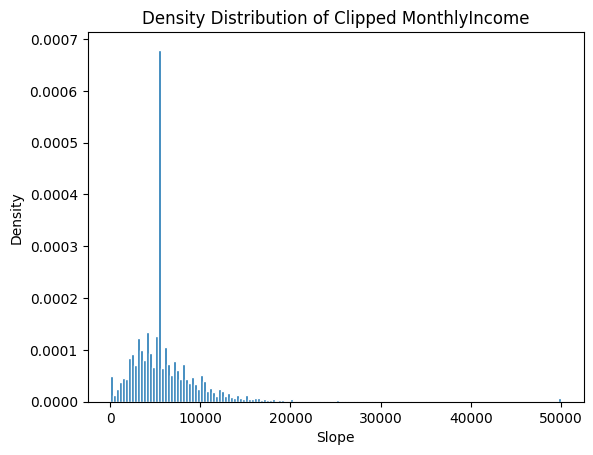

In [91]:
train_df['MonthlyIncome_imputed'] = train_df['MonthlyIncome_imputed'].clip(lower=0, upper=50000)

plt.hist(train_df['MonthlyIncome_imputed'], bins=150, ec='white', density=True)
plt.title('Density Distribution of Clipped MonthlyIncome')
plt.ylabel('Density')
plt.xlabel('Slope')

### Model 5 - Training

In [92]:
X_model5 = train_df[['age_bin_mid', 
                     'DebtRatio_bin_mid', 
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate',
                     'log_RevolvingUtilizationOfUnsecuredLines',
                     'MonthlyIncome_imputed',
                     'MonthlyIncome_missing',
                    ]]
Y_model5 = train_df['SeriousDlqin2yrs']

In [93]:
# initialize the model
model5 = LogisticRegression(C=1e2, max_iter=2000)

# fit the model
model5.fit(X_model5, Y_model5)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",100.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`m

In [94]:
X_test5 = pd.DataFrame([[25, 1.5, 2, 1, 0, np.log1p(0.5), 5000, 0], 
                        [45, 1.5, 2, 0, 1, np.log1p(0.5), 1000, 1], 
                        [95, 1.5, 0, 1, 0, np.log1p(0.5), 2000, 0]
                       ], 
                      columns=[
                          'age_bin_mid', 
                          'DebtRatio_bin_mid',
                          'NumberOfTime30-59DaysPastDueNotWorse',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                          'NumberOfTimes90DaysLate',
                          'log_RevolvingUtilizationOfUnsecuredLines',
                          'MonthlyIncome_imputed',
                          'MonthlyIncome_missing'
                      ])

print(model5.predict(X_test5))
print(model5.predict_proba(X_test5))

[0 0 0]
[[0.71949289 0.28050711]
 [0.82625212 0.17374788]
 [0.94471095 0.05528905]]


### Model 5 - Accuracy Calculation:

In [95]:
# Accuracy for training set:
model5.score(X_model5, Y_model5)

0.9369078075650631

In [96]:
X_val_model5 = val_df[['age_bin_mid', 
                       'DebtRatio_bin_mid', 
                       'NumberOfTime30-59DaysPastDueNotWorse',
                       'NumberOfTime60-89DaysPastDueNotWorse',
                       'NumberOfTimes90DaysLate',
                       'log_RevolvingUtilizationOfUnsecuredLines',
                       'MonthlyIncome_imputed',
                       'MonthlyIncome_missing'
                      ]]
Y_val_model5 = val_df['SeriousDlqin2yrs']

In [97]:
# Accuracy for validation set:
model5.score(X_val_model5, Y_val_model5)

0.9363333333333334

In [98]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs5 = [accuracy_custom_threshold(model5, X_val_model5, Y_val_model5, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs5)

np.int64(52)

### Model 5 - Precision and Recall Calculations:

In [99]:
precs5 = [precision_custom_threshold(model5, X_val_model5, Y_val_model5, t) for t in thresholds]
recs5 = [recall_custom_threshold(model5, X_val_model5, Y_val_model5, t) for t in thresholds]

In [100]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs5))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs5))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 5:')

In [101]:
coefficients = model5.coef_[0]  # shape = (n_features,)
intercept = model5.intercept_[0]

# Map coefficients to feature names
feature_names = X_model5.columns
for feat, coef in zip(feature_names, coefficients):
    print(f"{feat}: {coef:.4f}")

print(f"Intercept: {intercept:.4f}")

age_bin_mid: -0.0134
DebtRatio_bin_mid: 0.2112
NumberOfTime30-59DaysPastDueNotWorse: 0.4922
NumberOfTime60-89DaysPastDueNotWorse: 0.4466
NumberOfTimes90DaysLate: 0.6781
log_RevolvingUtilizationOfUnsecuredLines: 2.6014
MonthlyIncome_imputed: -0.0000
MonthlyIncome_missing: -0.6139
Intercept: -3.3692


In [102]:
# MonthlyIncome_missing will be dropped in the training of Model 5b

### Model 5b - Training

In [103]:
X_model5b = train_df[['age_bin_mid', 
                     'DebtRatio_bin_mid', 
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate',
                     'log_RevolvingUtilizationOfUnsecuredLines',
                     'MonthlyIncome_imputed',
                    ]]
Y_model5b = train_df['SeriousDlqin2yrs']

In [104]:
# initialize the model
model5b = LogisticRegression(C=1e2, max_iter=2000)

# fit the model
model5b.fit(X_model5b, Y_model5b)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",100.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`m

In [105]:
X_test5b = pd.DataFrame([[25, 1.5, 2, 1, 0, np.log1p(0.5), 5000], 
                        [45, 1.5, 2, 0, 1, np.log1p(0.5), 1000], 
                        [95, 1.5, 0, 1, 0, np.log1p(0.5), 1000]
                       ], 
                      columns=[
                          'age_bin_mid', 
                          'DebtRatio_bin_mid',
                          'NumberOfTime30-59DaysPastDueNotWorse',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                          'NumberOfTimes90DaysLate',
                          'log_RevolvingUtilizationOfUnsecuredLines',
                          'MonthlyIncome_imputed',
                      ])

print(model5b.predict(X_test5b))
print(model5b.predict_proba(X_test5b))

[0 0 0]
[[0.758      0.242     ]
 [0.75815423 0.24184577]
 [0.9547811  0.0452189 ]]


### Model 5b - Accuracy Calculation:

In [106]:
# Accuracy for training set:
model5b.score(X_model5b, Y_model5b)

0.936857807148393

In [107]:
X_val_model5b = val_df[['age_bin_mid', 
                       'DebtRatio_bin_mid', 
                       'NumberOfTime30-59DaysPastDueNotWorse',
                       'NumberOfTime60-89DaysPastDueNotWorse',
                       'NumberOfTimes90DaysLate',
                       'log_RevolvingUtilizationOfUnsecuredLines',
                       'MonthlyIncome_imputed',
                      ]]
Y_val_model5b = val_df['SeriousDlqin2yrs']

In [108]:
# Accuracy for validation set:
model5b.score(X_val_model5b, Y_val_model5b)

0.9357666666666666

In [109]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs5b = [accuracy_custom_threshold(model5b, X_val_model5b, Y_val_model5b, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs5b)

np.int64(58)

### Model 5b - Precision and Recall Calculations:

In [110]:
precs5b = [precision_custom_threshold(model5b, X_val_model5b, Y_val_model5b, t) for t in thresholds]
recs5b = [recall_custom_threshold(model5b, X_val_model5b, Y_val_model5b, t) for t in thresholds]

In [111]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs5b))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs5b))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 5b:')

## Feature 6: NumberOfOpenCreditLinesAndLoans

### EDA - NumberOfOpenCreditLinesAndLoans

In [112]:
train_df['NumberOfOpenCreditLinesAndLoans'].describe()

count    119999.000000
mean          8.460871
std           5.132688
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          40.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Text(0.5, 0, 'Slope')

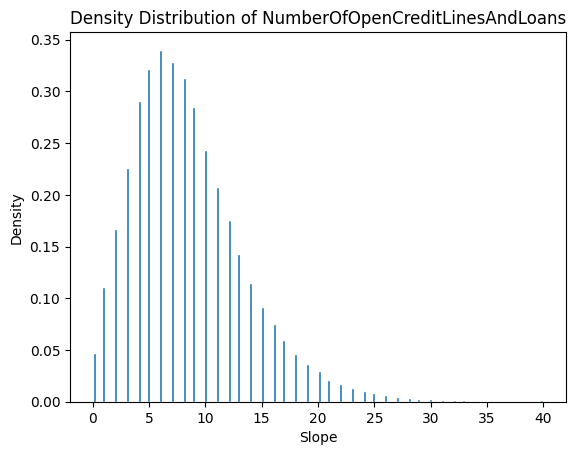

In [113]:
train_df['NumberOfOpenCreditLinesAndLoans'] = train_df['NumberOfOpenCreditLinesAndLoans'].clip(lower=0, upper=40)

plt.hist(train_df['NumberOfOpenCreditLinesAndLoans'], bins=150, ec='white', density=True)
plt.title('Density Distribution of NumberOfOpenCreditLinesAndLoans')
plt.ylabel('Density')
plt.xlabel('Slope')

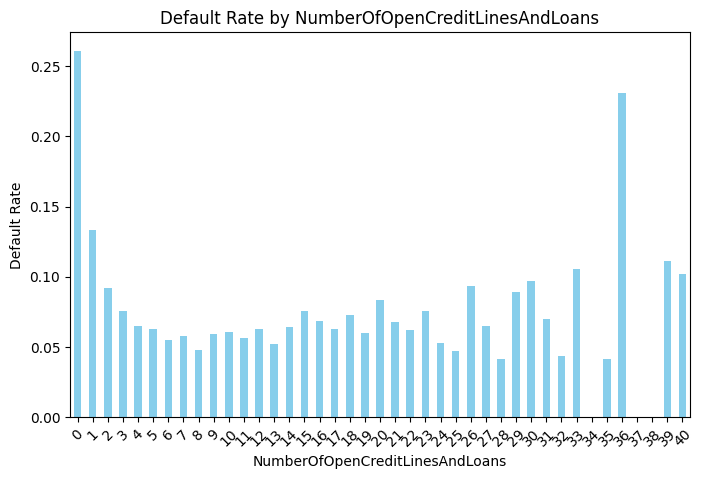

In [114]:
rate_per_bin = train_df.groupby('NumberOfOpenCreditLinesAndLoans', observed=True)['SeriousDlqin2yrs'].mean()
plt.figure(figsize=(8,5))
rate_per_bin.plot(kind='bar', color='skyblue')
plt.xlabel('NumberOfOpenCreditLinesAndLoans')
plt.ylabel('Default Rate')
plt.title('Default Rate by NumberOfOpenCreditLinesAndLoans')
plt.xticks(rotation=45)
plt.show()

### Model 6 - Training

In [115]:
X_model6 = train_df[['age_bin_mid', 
                     'DebtRatio_bin_mid', 
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate',
                     'log_RevolvingUtilizationOfUnsecuredLines',
                     'MonthlyIncome_imputed',
                     'NumberOfOpenCreditLinesAndLoans'
                    ]]
Y_model6 = train_df['SeriousDlqin2yrs']

In [116]:
# initialize the model
model6 = LogisticRegression(C=1e2, max_iter=2000)

# fit the model
model6.fit(X_model6, Y_model6)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",100.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`m

In [140]:
X_test6 = pd.DataFrame([[25, 1.125, 2, 1, 0, np.log1p(0.4054651081081644), 5000, 0], 
                        [45, 1.125, 2, 0, 1, np.log1p(0.4054651081081644), 1000, 4], 
                        [95, 1.125, 0, 1, 0, np.log1p(0.4054651081081644), 1000, 2],
                        [25, 2.8755, 2, 5, 6, np.log1p(0.4054651081081644), 2000, 8],
                       ], 
                      columns=[
                          'age_bin_mid', 
                          'DebtRatio_bin_mid',
                          'NumberOfTime30-59DaysPastDueNotWorse',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                          'NumberOfTimes90DaysLate',
                          'log_RevolvingUtilizationOfUnsecuredLines',
                          'MonthlyIncome_imputed',
                          'NumberOfOpenCreditLinesAndLoans'
                      ])

print(model6.predict(X_test6))
print(model6.predict_proba(X_test6))

[0 0 0 1]
[[0.83293125 0.16706875]
 [0.80663541 0.19336459]
 [0.97063989 0.02936011]
 [0.00872866 0.99127134]]


### Model 6 - Accuracy Calculation:

In [118]:
# Accuracy for training set:
model6.score(X_model6, Y_model6)

0.9368078067317228

In [119]:
X_val_model6 = val_df[['age_bin_mid', 
                       'DebtRatio_bin_mid', 
                       'NumberOfTime30-59DaysPastDueNotWorse',
                       'NumberOfTime60-89DaysPastDueNotWorse',
                       'NumberOfTimes90DaysLate',
                       'log_RevolvingUtilizationOfUnsecuredLines',
                       'MonthlyIncome_imputed',
                       'NumberOfOpenCreditLinesAndLoans'
                      ]]
Y_val_model6 = val_df['SeriousDlqin2yrs']

In [120]:
# Accuracy for validation set:
model6.score(X_val_model6, Y_val_model6)

0.9361666666666667

In [121]:
# Simulates each treshold
thresholds = np.linspace(0, .99, 100)
accs6 = [accuracy_custom_threshold(model6, X_val_model6, Y_val_model6, t) for t in thresholds]
# The threshold that maximizes validation accuracy
np.argmax(accs6)

np.int64(53)

### Model 6 - Precision and Recall Calculations:

In [122]:
precs6 = [precision_custom_threshold(model6, X_val_model6, Y_val_model6, t) for t in thresholds]
recs6 = [recall_custom_threshold(model6, X_val_model6, Y_val_model6, t) for t in thresholds]

In [123]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs6))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs6))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig.update_layout(width=600, height=600, title_text='Precision–recall vs threshold for Model 6:')

In [124]:
coefficients2 = model6.coef_[0]  # shape = (n_features,)
intercept2 = model6.intercept_[0]

# Map coefficients to feature names
feature_names2 = X_model6.columns
for feat, coef in zip(feature_names2, coefficients2):
    print(f"{feat}: {coef:.4f}")

print(f"Intercept: {intercept2:.4f}")

age_bin_mid: -0.0160
DebtRatio_bin_mid: 0.0077
NumberOfTime30-59DaysPastDueNotWorse: 0.4712
NumberOfTime60-89DaysPastDueNotWorse: 0.4415
NumberOfTimes90DaysLate: 0.7011
log_RevolvingUtilizationOfUnsecuredLines: 2.7130
MonthlyIncome_imputed: -0.0000
NumberOfOpenCreditLinesAndLoans: 0.0349
Intercept: -3.4009


### ROC

In [125]:
loan_model2 = model6        # Fit to model 6
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def tpr_threshold(X, Y, T): # This is recall
    Y_hat = predict_threshold(loan_model2, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(loan_model2, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

In [126]:
# Compute for different thresholds
thresholds = np.linspace(0, 1, 100)
tprs2 = [tpr_threshold(X_val_model6, Y_val_model6, t) for t in thresholds]
fprs2 = [fpr_threshold(X_val_model6, Y_val_model6, t) for t in thresholds]

In [127]:
fig = px.line(x=fprs2, y = tprs2, hover_name=thresholds, title="ROC Curve")
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

In [128]:
metrics.roc_auc_score(Y_val_model6, model6.predict_proba(X_val_model6)[:, 1])

0.8559187849273049

## Test

### Prep:

In [129]:
# # Training set binning of age
# test_data['age_bin'] = pd.cut(test_data['age'], bins=[20,30,40,50,60,70,80,110], right=False )
# test_data['age_bin_mid'] = test_data['age_bin'].apply(lambda x: (x.left + x.right)/2)

# # Training set binning Debt Ratio
# max_clip = 3
# test_data['DebtRatio'] = test_data['DebtRatio'].clip(upper=max_clip)
# test_data['DebtRatio_bin'] = pd.cut(train_df['DebtRatio'], bins=[0, 0.25, 0.5, 0.75, 1, 
#                                                                 1.25, 1.5, 1.75, 2, 
#                                                                 2.25, 2.5, 2.75, 3.001,
#                                                                ], right=False, include_lowest=True)
# test_data['DebtRatio_bin_mid'] = test_data['DebtRatio_bin'].apply(lambda x: (x.left + x.right)/2)


# # Delinquencies
# # 30-60 day, clip at 4 (EDA is in Feature 3 section)
# test_data['NumberOfTime60-89DaysPastDueNotWorse'] = test_data['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=4)
# # 60-90 day, clip at 4 (EDA is in Feature 3 section)
# test_data['NumberOfTime30-59DaysPastDueNotWorse'] = test_data['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=4)
# # 90 day, clip at 4 (EDA is in Feature 3 section)
# test_data['NumberOfTimes90DaysLate'] = test_data['NumberOfTimes90DaysLate'].clip(upper=4)

# # Revolving Utilization Of Unsecured Lines
# test_data['RevolvingUtilizationOfUnsecuredLines'] = test_data['RevolvingUtilizationOfUnsecuredLines'].clip(lower=0, upper=3)
# test_data['log_RevolvingUtilizationOfUnsecuredLines'] = np.log1p(test_data['RevolvingUtilizationOfUnsecuredLines'])

# # Monthly Income
# test_data['MonthlyIncome_missing'] = test_data['MonthlyIncome'].isna().astype(int)
# income_median = train_df['MonthlyIncome'].median()
# test_data['MonthlyIncome_imputed'] = test_data['MonthlyIncome'].fillna(income_median)
# test_data['MonthlyIncome_imputed'] = test_data['MonthlyIncome_imputed'].clip(lower=0, upper=50000)

# # Number Of Open Credit Lines And Loans
# test_data['NumberOfOpenCreditLinesAndLoans'] = test_data['NumberOfOpenCreditLinesAndLoans'].clip(lower=0, upper=40)

In [130]:
# # Final Test DF Prep
# X_test = test_data[['age_bin_mid', 
#                     'DebtRatio_bin_mid', 
#                     'NumberOfTime30-59DaysPastDueNotWorse',
#                     'NumberOfTime60-89DaysPastDueNotWorse',
#                     'NumberOfTimes90DaysLate',
#                     'log_RevolvingUtilizationOfUnsecuredLines',
#                     'MonthlyIncome_imputed',
#                     'NumberOfOpenCreditLinesAndLoans'
#                     ]]
# Y_test = test_data['SeriousDlqin2yrs']

In [131]:
# test_data.head()

In [132]:
# model6.score(X_test, Y_test)

## Conclusions for Neurosymbolic System:

In [133]:
# Features acurrately predict high risk applicants. While more feature engineering could be warranted,
# the ML model is at a good stopping point for the proto / POC. 

# Note: 
# Precision = fraction of flagged applicants who actually default
# Recall = fraction of actual defaulters you catch

### Threshold Selection:

In [134]:
# Crossover threshold used will be 0.16 with proportion flagged ~40.3% and a recall of ~47.3%


# This means:

# Consider applicants with predicted probability ≥ 0.16 as high risk.

# Precision = 0.403 or about 40% of flagged applicants actually default, 
# which is roughly 6× the base default rate (~6–7%).

# Recall = 0.473 or we catch 47% of all actual defaulters at this threshold.
# This threshold prioritizes finding high-risk borrowers without flagging too many low-risk ones.

# Note:
# ~40% precision may seem low, but for rare-event prediction, this is expected.